#### Importing libraries

In [ ]:
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.models import load_model
from keras import metrics
from matplotlib import pyplot
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import random
from datetime import datetime
from datetime import timedelta
import os
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
%matplotlib notebook
import time
from keras.optimizers import Adam

# pip install autotime
# %load_ext autotime

In [ ]:
# GPU Setup
import tensorflow as tf
from tensorflow.python.client import device_lib


### Preparing Dataset

In [ ]:
!wget "https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/driving_dataset.zip"

--2023-02-15 11:41:53--  https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/driving_dataset.zip
Resolving anonymous.4open.science (anonymous.4open.science)... 172.67.183.76, 104.21.18.195, 2606:4700:3037::6815:12c3, ...
Connecting to anonymous.4open.science (anonymous.4open.science)|172.67.183.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘driving_dataset.zip’

driving_dataset.zip     [       <=>          ]  12.46M  9.85MB/s    in 1.3s    

2023-02-15 11:42:02 (9.85 MB/s) - ‘driving_dataset.zip’ saved [13066559]



In [ ]:
!unzip "driving_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: icnp-dataset/ATT/handoff_571/nbr_0.csv  
   creating: icnp-dataset/ATT/handoff_1561/
  inflating: icnp-dataset/ATT/handoff_1561/nbr_2.csv  
  inflating: icnp-dataset/ATT/handoff_1561/nbr_1.csv  
  inflating: icnp-dataset/ATT/handoff_1561/nbr_0.csv  
  inflating: icnp-dataset/ATT/handoff_1561/nbr_3.csv  
   creating: icnp-dataset/ATT/handoff_560/
  inflating: icnp-dataset/ATT/handoff_560/nbr_2.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_4.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_1.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_6.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_7.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_0.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_5.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_3.csv  
   creating: icnp-dataset/ATT/handoff_1224/
  inflating: icnp-dataset/ATT/handoff_1224/nbr_2.csv  
  inflating: icnp-dataset/ATT/handoff_1224/nbr_1.csv  
  

#  Loading Data with Timestamps

In [ ]:
dataset_master_folders = ["icnp-dataset/ATT", "icnp-dataset/TMobile"]

WINDOW_SIZE = 5

def string_to_datetime(timestamp):
  return float(timestamp)

# This function extracts the rsrp, rsrq and labels, along with assigning the specific dataframe a "time to prediction"
def add_to_df_wts(filepath, window_size):
  df = pd.read_csv(filepath)
  # df.drop(["Unnamed: 0"], axis=1, inplace=True)
  
  entries = []

  # Getting timestamp for handover (or at least as close to it as possible)
  last_entry = df.iloc[-1]
  last_entry_ts = last_entry["timestamp"]
  ho_ts_datetime = string_to_datetime(last_entry_ts)

  if df.shape[0] >= window_size:
    for i in range(0, df.shape[0]-window_size):
      # Extracting the last timestamp for this window
      last_window_entry = df.iloc[i+window_size]
      last_window_ts = last_window_entry["timestamp"]
      lw_ts_dt = string_to_datetime(last_window_ts) # last window timestamp datetime object
      
      # Calculating time to handover and adding it to ttp
      tth = ho_ts_datetime - lw_ts_dt # time to handover
      # tth_seconds = tth.total_seconds()
      tth_seconds = tth

      # Extracting the rest
      temp = df.iloc[i:i+window_size]
      rsrp = temp["rsrp"]
      rsrq = temp["rsrq"]
      rsrp_raw = temp["rsrp_raw"]
      rsrq_raw = temp["rsrq_raw"]
      label = df.iloc[i]
      label = label["label"]

      entry = []
      entry.append(rsrp)
      entry.append(rsrq)
      entry.append(label)
      entry.append(tth_seconds)
      entry.append(rsrp_raw)
      entry.append(rsrq_raw)

      entries.append(entry)

    return entries

  return

sequence_dict = {}


ho_event_no = 0 # This counter keeps track of which handover event we have reached
for master_f in dataset_master_folders:
  dataset_folders = os.listdir(master_f)
  for folder in dataset_folders:
    folder_path = master_f + "/" + folder
    files = os.listdir(folder_path)
    ho_event_no += 1
    curr_hoevent_entries = [] # list containing all the data for the current handover event
    for f in files:
      filepath = folder_path + "/" + f
      entries = add_to_df_wts(filepath, WINDOW_SIZE)
      curr_hoevent_entries.append(entries)
    sequence_dict[ho_event_no] = curr_hoevent_entries

sequence_dict_orig = sequence_dict.copy()

In [ ]:
# Renaming the labels and converting into required data types

# sequence_dict = sequence_dict_orig.copy()

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  for i1, entry in enumerate(ho_event_list):
    if entry is not None:
      for i2, subentry in enumerate(entry):
        if subentry[2] == "not_target":
          sequence_dict[key][i1][i2][2] = 0
        else:
          sequence_dict[key][i1][i2][2] = 1

sequence_dict_renamed = sequence_dict.copy()

In [ ]:
# Function to detect if there are no "target" entries in here
def check_valid(sequence_dict, key):
  ho_event_list = sequence_dict[key]
  for i, base_station_entries in enumerate(ho_event_list):
    # each base station contains a sequence of measurements at that point for this specific base station
    if base_station_entries != [] and base_station_entries is not None:
      label = sequence_dict[key][i][0][2]
      # print(sequence_dict[key][i][0][2])
      if label == 1:
        return True
  return False 

check_valid(sequence_dict, 1)

True

In [ ]:
sequence_dict = sequence_dict_orig.copy()

# Using minmax scaling to bring our features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

rsrp_list = []
rsrq_list = []
rsrp_raws_list = []
rsrq_raws_list = []
labels = []

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid(sequence_dict, key):
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          req_idx = len(rsrp_list)
          rsrp = np.array(sequence_dict[key][i1][i2][0])
          rsrq = np.array(sequence_dict[key][i1][i2][1])
          label = np.array(sequence_dict[key][i1][i2][2])
          rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
          rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
          rsrp_list.append(rsrp)
          rsrq_list.append(rsrq)
          rsrp_raws_list.append(rsrp_raws)
          rsrq_raws_list.append(rsrq_raws)
          labels.append(label)
          sequence_dict[key][i1][i2][0] = req_idx
          sequence_dict[key][i1][i2][1] = req_idx
          sequence_dict[key][i1][i2][4] = req_idx
          sequence_dict[key][i1][i2][5] = req_idx
          # sequence_dict[key][i1][i2][2] = req_idx
        
rsrp_tts = scaler.fit_transform(rsrp_list)
rsrq_tts = scaler.fit_transform(rsrq_list)
rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

# Combining features
features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

# Reshaping label data
labels = np.reshape(labels, (len(labels),1))

This gives us a 1-1 mapping between event handover event and its data, along with indexable paths mapping the two, which we can use to evaluate the earliest time to prediction.

# Time To Prediction Statistics

In [ ]:
# Loading model
# If you have modified the WINDOW_SIZE variable above, then load the correct model for the corresponding Window Size. You can find the models here:
# https://anonymous.4open.science/r/EdgeCatBSPDataset-1840/README.md
# Click on the model's file, and get the link from the "Download" button. 

!wget "https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/models/model_WS5.h5" -O "model.h5"

model_eval = load_model("model.h5")

--2023-02-15 11:47:45--  https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/models/model_WS5.h5
Resolving anonymous.4open.science (anonymous.4open.science)... 104.21.18.195, 172.67.183.76, 2606:4700:3035::ac43:b74c, ...
Connecting to anonymous.4open.science (anonymous.4open.science)|104.21.18.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘model.h5’

model.h5                [ <=>                ] 253.73K  --.-KB/s    in 0.04s   

2023-02-15 11:47:46 (6.12 MB/s) - ‘model.h5’ saved [259816]



## Inference Time

In [ ]:
# GPU warmup

with tf.device('/device:GPU:0'):
  predictions_orig = model_eval.predict(features)
  predictions = (predictions_orig > 0.37)
  cm = confusion_matrix(labels, predictions)

  tn, fp, fn, tp = cm.ravel()

with tf.device('/device:CPU:0'):
  # start_time = time.perf_counter()            
  predictions_orig = model_eval.predict(features)
  predictions = (predictions_orig > 0.37)
  cm = confusion_matrix(labels, predictions)
  tn, fp, fn, tp = cm.ravel()

8252/8252 [==============================] - 31s 4ms/step


In [ ]:
def inference_time_eval(model, features, batch_size):
  print("For batch size:", batch_size)
     
  with tf.device('/device:GPU:0'):
    start_time = time.perf_counter()
    predictions_orig = model_eval.predict(features, batch_size=batch_size)
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    print(execution_time)

def inference_time_eval_CPU(model, features, batch_size):
  print("For batch size:", batch_size)
  start_time = time.perf_counter()   
  with tf.device('/device:CPU:0'):
    predictions_orig = model_eval.predict(features, batch_size=batch_size)
  end_time = time.perf_counter()
  execution_time = end_time - start_time
  print(execution_time)  

In [ ]:
inference_time_eval_CPU(model_eval, features, 64)
inference_time_eval_CPU(model_eval, features, 128)
inference_time_eval_CPU(model_eval, features, 256)
inference_time_eval_CPU(model_eval, features, 512)
inference_time_eval_CPU(model_eval, features, 1024)
inference_time_eval_CPU(model_eval, features, 2048)
inference_time_eval_CPU(model_eval, features, 4096)
inference_time_eval_CPU(model_eval, features, 8192)
inference_time_eval_CPU(model_eval, features, 16384)
inference_time_eval_CPU(model_eval, features, 32768)

For batch size: 64
4126/4126 [==============================] - 14s 3ms/step
20.53996264400007
For batch size: 128
2063/2063 [==============================] - 9s 4ms/step
10.276007915000037
For batch size: 256
1032/1032 [==============================] - 5s 5ms/step
5.124999551999963
For batch size: 512
516/516 [==============================] - 4s 8ms/step
5.150016971000014
For batch size: 1024
258/258 [==============================] - 3s 13ms/step
5.17232786999989
For batch size: 2048
129/129 [==============================] - 2s 17ms/step
2.2833301519999623
For batch size: 4096
65/65 [==============================] - 2s 29ms/step
1.9660641510001824
For batch size: 8192
33/33 [==============================] - 2s 54ms/step
2.5902574030001233
For batch size: 16384
17/17 [==============================] - 3s 154ms/step
2.707576531999848
For batch size: 32768
9/9 [==============================] - 2s 190ms/step
1.7771776689999115


In [ ]:
inference_time_eval(model_eval, features, 64)
inference_time_eval(model_eval, features, 128)
inference_time_eval(model_eval, features, 256)
inference_time_eval(model_eval, features, 512)
inference_time_eval(model_eval, features, 1024)
inference_time_eval(model_eval, features, 2048)
inference_time_eval(model_eval, features, 4096)
inference_time_eval(model_eval, features, 8192)
inference_time_eval(model_eval, features, 16384)
inference_time_eval(model_eval, features, 32768)
inference_time_eval(model_eval, features, 32768*2)
inference_time_eval(model_eval, features, 32768*4)
inference_time_eval(model_eval, features, 32768*8)

For batch size: 64
4126/4126 [==============================] - 11s 3ms/step
11.850130833000094
For batch size: 128
2063/2063 [==============================] - 5s 2ms/step
10.275234480000108
For batch size: 256
1032/1032 [==============================] - 3s 3ms/step
3.4564439929999935
For batch size: 512
516/516 [==============================] - 1s 3ms/step
2.600096074000021
For batch size: 1024
258/258 [==============================] - 1s 3ms/step
0.8861599770000339
For batch size: 2048
129/129 [==============================] - 0s 3ms/step
0.6883279489998131
For batch size: 4096
65/65 [==============================] - 0s 3ms/step
0.3663188790001186
For batch size: 8192
33/33 [==============================] - 0s 3ms/step
0.18662434700013364
For batch size: 16384
17/17 [==============================] - 0s 5ms/step
0.2058114349999869
For batch size: 32768
9/9 [==============================] - 0s 7ms/step
0.13836503999982597
For batch size: 65536
5/5 [============================

In [ ]:
# Using __call__ method directly, 
BATCH_LENGTH = 25000
execution_times = []

for i in range(500):
  for i in range(len(features)//BATCH_LENGTH - 1):
    try:
      feature_selection = features[BATCH_LENGTH*i:BATCH_LENGTH*(i+1)]
      start_time = time.perf_counter()
      with tf.device('/device:GPU:0'):
        predictions = model_eval(feature_selection)
      end_time = time.perf_counter()
      execution_time = end_time - start_time
      execution_times.append(execution_time)
    except:
      pass # pass if there is a problem in the iter

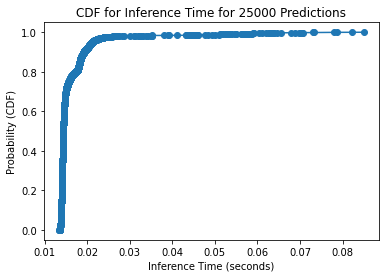

,0
count,4500.000000
mean,0.016119
std,0.005958
min,0.013456
25%,0.014096
50%,0.014385
75%,0.015735
max,0.084935


In [ ]:
%matplotlib inline
# Remove erroneous entries, i.e. where prediction was being made after the HO event
execution_times = list(filter(lambda ttp: ttp >= 0, execution_times))


# MODIFY THIS FILEPATH TO SAVE YOUR RESULTS
SAVEFILEPATH = "25000inferences.txt"

# UNCOMMENT THESE LINES TO SAVE
file = open(SAVEFILEPATH,'w')
for t in execution_times:
	file.write(str(t)+"\n")
file.close()

# Declare num of datapoints

N = len(execution_times)

x = np.sort(execution_times)
y = np.arange(N) / float(N)

plt.xlabel("Inference Time (seconds)")
plt.ylabel("Probability (CDF)")
plt.title("CDF for Inference Time for " + str(BATCH_LENGTH) + " Predictions")

plt.plot(x,y, marker='o')
plt.show()

earliest_times_df = pd.DataFrame(execution_times)
earliest_times_df.describe()

## Time to Prediction Evaluation

In [ ]:
with open("prognos_triggers.txt") as f:
  prognos_triggers = f.readlines()

# remove new line characters
prognos_triggers = [float(x.strip()) for x in prognos_triggers]

prognos_triggers = [x for x in prognos_triggers if x != 0]

random.shuffle(prognos_triggers)

print(prognos_triggers)

In [ ]:
def check_valid_2(sd, key):
  ho_event_list = sd[key]
  for i, base_station_entries in enumerate(ho_event_list):
    # each base station contains a sequence of measurements at that point for this specific base station
    if base_station_entries != [] and base_station_entries is not None:
      label = sequence_dict[key][i][0][2]
      if label == 1:
        return True
  return False

# Required statistics: %age of handover events where a correct prediction is made
# Storing the earliest time to prediction
# Total number of base stations predicted as true

earliest_times = []

# predictions_orig = model_eval.predict(features)
predictions_orig = model_eval(features)
predictions = (predictions_orig > 0.37)

valid_entries_count = 0

for HANDOVER_NUMBER, key in enumerate(sequence_dict.keys()):
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    CORRESPONDING_TIME = prognos_triggers[valid_entries_count]
    valid_entries_count += 1
    # We are now in the measurements for the current entry
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          req_idx = sequence_dict[key][i1][i2][0]
          label = labels[req_idx][0]
          curr_time = sequence_dict[key][i1][i2][3]
          if curr_time <= CORRESPONDING_TIME:
            if label == 1:
              # this subentry doesnt have the required entry for time to prediction
              # break
              prediction = predictions[req_idx]
              if bool(prediction) == True:
                # print(sequence_dict[key][i1][i2][3])
                earliest_times.append(sequence_dict[key][i1][i2][3])
                break
        

In [ ]:
# Conflict Resolution Implementation

# Dictionary to contain the prediction values for correct and false target predictions
predictions_per_ho = []
time_idx = 0
exec_times = []

for key in sequence_dict.keys():
  start_time = time.perf_counter()            
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    # Now looking at the current handover event
    
    per_timestamp_dict = {}

    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        # Making 2 dictionaries, one for the earliest correct prediction, and the other for all incorrect predictions        

        for i2, subentry in enumerate(entry):
          req_idx = sequence_dict[key][i1][i2][0]
          label = labels[req_idx][0]

          if label == 1:
            # Label for true prediction
            prediction = predictions[req_idx]
            if bool(prediction) == True:
              # True positive case
              time_idx = sequence_dict[key][i1][i2][3]
              
              try: 
                per_timestamp_dict[time_idx]
                per_timestamp_dict[time_idx]["correct"] = predictions_orig[req_idx]
              except:
                per_timestamp_dict[time_idx] = {}
                per_timestamp_dict[time_idx]["correct"] = predictions_orig[req_idx]
                
          if label == 0:
            prediction = predictions[req_idx]
            
            if bool(prediction) == True:
              # False negative case

              try:
                per_timestamp_dict[time_idx]
              except:
                per_timestamp_dict[time_idx] = {}
              
              try:
                per_timestamp_dict[time_idx]["incorrect"]
                per_timestamp_dict[time_idx]["incorrect"].append(predictions_orig[req_idx])
              except:
                per_timestamp_dict[time_idx]["incorrect"] = [predictions_orig[req_idx]]


              # if per_timestamp_dict[time_idx] is None:
              #   per_timestamp_dict[time_idx] = {}
              #   if per_timestamp_dict[time_idx]["incorrect"] is None:
              #     per_timestamp_dict[time_idx]["incorrect"] = [predictions_orig[req_idx]]
              #   else:
              #     per_timestamp_dict[time_idx]["incorrect"].append(predictions_orig[req_idx])

    predictions_per_ho.append(per_timestamp_dict)  
  end_time = time.perf_counter()            
  execution_time = end_time - start_time
  exec_times.append(execution_time)

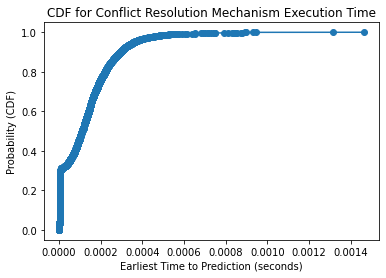

                  0
count  3.947000e+03
mean   1.289293e-04
std    1.324764e-04
min    8.330000e-07
25%    4.630000e-06
50%    1.097130e-04
75%    1.948230e-04
max    1.462880e-03


In [ ]:
# print(len(earliest_times))
%matplotlib inline
# Remove erroneous entries, i.e. where prediction was being made after the HO event
exec_times = list(filter(lambda ttp: ttp >= 0, exec_times))

# MODIFY THIS VARIABLE TO YOUR DESIRED LOCATION TO SAVE THIS FILE AND UNCOMMENT THE LINES BELOW
SAVEFILEPATH2 = ""

# file = open(SAVEFILEPATH2,'w')
# for t in exec_times:
# 	file.write(str(t)+"\n")
# file.close()

# Declare num of datapoints

N = len(exec_times)

x = np.sort(exec_times)
y = np.arange(N) / float(N)

plt.xlabel("Earliest Time to Prediction (seconds)")
plt.ylabel("Probability (CDF)")
plt.title("CDF for Conflict Resolution Mechanism Execution Time")

plt.plot(x,y, marker='o')
plt.show()

earliest_times_df = pd.DataFrame(exec_times)
print(earliest_times_df.describe())

In [ ]:
cm = confusion_matrix(labels, predictions)
tn, fp, fn, tp = cm.ravel()

In [ ]:
fp_total = 0

for i, prediction_dict in enumerate(predictions_per_ho):
  for key in prediction_dict.keys():
    current_entry = prediction_dict[key]
    try:
      current_entry["incorrect"]

      fp_total += len(current_entry["incorrect"])
    except:
      pass

print("False positives total:", fp_total)

fp_avoidable = 0

for i, prediction_dict in enumerate(predictions_per_ho):
  for key in prediction_dict.keys():
    current_entry = prediction_dict[key]
    try:
      current_entry["incorrect"]
      current_entry["correct"]

      fp_avoidable += len(current_entry["incorrect"])
    except:
      pass

print("Avoidable false positives:", fp_avoidable)

fp_removed = 0

new_fps = 0
tps_gone = 0


for i, prediction_dict in enumerate(predictions_per_ho):
  for key in prediction_dict.keys():
    current_entry = prediction_dict[key]
    try:
      current_entry["incorrect"]
      current_entry["correct"]
      
      correct_confidence = current_entry["correct"]
      incorrect_confidences = current_entry["incorrect"]

      # print("Correct confidence:", correct_confidence[0])
      mispredict = False

      for conf in incorrect_confidences:
        if conf[0] < correct_confidence:
          fp_removed += 1
        else:
          # print("Difference: ", conf[0] - correct_confidence)
          # if (conf[0] - correct_confidence) > 0.1:
          #   new_fps += 1
          mispredict = True

      if mispredict:
        tps_gone += 1

    except:
      pass

print("False positives removed: ", fp_removed)

print("Percentage of false positives removed out of total: ", fp_removed/fp_total * 100)
print("Percentage of false positives removed out of avoidable total: ", fp_removed/fp_avoidable * 100)

print("Number of True Positives lost to misprediction:", tps_gone)

False positives total: 41735
Avoidable false positives: 36041
False positives removed:  28514
Percentage of false positives removed out of total:  68.32155265364803
Percentage of false positives removed out of avoidable total:  79.11545184650815
Number of True Positives lost to misprediction: 523


Old results:
True Positives: 61230
False Positives: 41735
False Negatives: 15133
True Negatives: 145941
New Results
0.8078594193930443


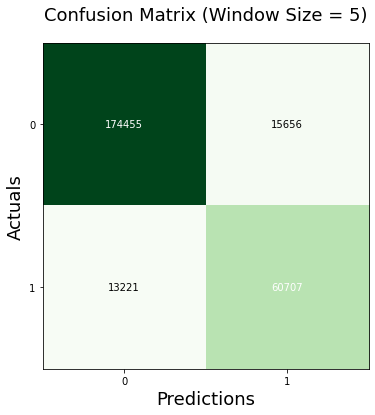

In [ ]:
%matplotlib inline

print("Old results:")
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Negatives:", tn)

# Updates made after the introduction of 
new_fp = fp - fp_removed
new_tp = tp - tps_gone
new_tn = tn + fp_removed
new_fn = fn + tps_gone
cm = np.array([[new_tn, new_fn], [new_fp ,new_tp]])

precision = new_tp/(new_tp+new_fp)
recall = new_tp/(new_tp+new_fn)

print("New Results")

f1_score = 2*precision*recall/(precision+recall)
print(f1_score)

fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix (Window Size = 5)', fontsize=18)
plt.show()

In [ ]:
# counting the number of handover events that have something to be predicted
count = 0
for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    count += 1

total_ho_count = count
print(count)

2719


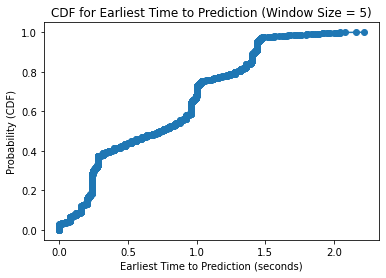

                 0
count  2560.000000
mean      0.719655
std       0.501750
min       0.000000
25%       0.240031
50%       0.737450
75%       1.036625
max       2.216027


In [ ]:
# print(len(earliest_times))
%matplotlib inline
# Remove erroneous entries, i.e. where prediction was being made after the HO event
earliest_times = list(filter(lambda ttp: ttp >= 0, earliest_times))

# Declare num of datapoints

N = len(earliest_times)

x = np.sort(earliest_times)
y = np.arange(N) / float(N)

plt.xlabel("Earliest Time to Prediction (seconds)")
plt.ylabel("Probability (CDF)")
plt.title("CDF for Earliest Time to Prediction (Window Size = 5)")

plt.plot(x,y, marker='o')
plt.show()

earliest_times_df = pd.DataFrame(earliest_times)
print(earliest_times_df.describe())

In [ ]:

g100 = 0
g200 = 0
g500 = 0
g1000 = 0

for x in earliest_times:
  if x >= 0.1:
    g100 += 1
  if x >= 0.2:
    g200 += 1
  if x >= 0.5:
    g500 += 1
  if x >= 1:
    g1000 += 1

print("100: ", g100/N * 100)
print("200: ", g200/N * 100)
print("500: ", g500/N * 100)
print("1000: ", g1000/N * 100)


100:  92.8515625
200:  85.8203125
500:  56.2109375
1000:  30.312499999999996


In [ ]:
print(earliest_times)

# Modify this variable a
FILEPREFIX = ""
file = open('prognos_hint_icnp_earliest_times.txt','w')
for t in earliest_times:
	file.write(str(t)+"\n")
file.close()

[1.0011110305786133, 0.23998284339904785, 1.3999910354614258, 0.2411198616027832, 1.0010459423065186, 0.15995407104492188, 1.4871721267700195, 1.441627025604248, 0.24001693725585938, 1.0328538417816162, 0.9989838600158691, 0.48074913024902344, 1.4012339115142822, 0.24000191688537598, 0.4011049270629883, 1.2410039901733398, 1.1199851036071777, 0.2711300849914551, 1.2410309314727783, 0.5999901294708252, 1.361840009689331, 1.7199749946594238, 0.0, 0.961082935333252, 0.0, 0.24112915992736816, 0.20316004753112793, 0.2799859046936035, 0.5199401378631592, 0.7000491619110107, 0.20005393028259277, 0.24248909950256348, 1.1999998092651367, 1.278791904449463, 0.4789769649505615, 1.4025840759277344, 1.000072956085205, 0.20008111000061035, 0.8757078647613525, 0.3600029945373535, 1.0011069774627686, 0.2400660514831543, 0.9992690086364746, 0.2440938949584961, 0.9608149528503418, 0.7599658966064453, 0.2400801181793213, 0.24128293991088867, 1.021111011505127, 1.275752067565918, 0.16892313957214355, 1.44

In [ ]:
# Calculating #age of events missed by the algorithm
num_predicted = len(earliest_times_df)
percentage_missed = (total_ho_count - num_predicted) / total_ho_count * 100
print("Percentage of handover events for which predictions could not be made:", percentage_missed)

Percentage of handover events for which predictions could not be made: 1.250459727841118


[1.036122, 1.602726, 0.28005, 1.47581, 1.47581, 0.28005, 1.036122, 0.28005, 1.559297, 1.47581, 0.28005, 1.036122, 1.036122, 0.64194, 1.47581, 0.28005, 0.418951, 1.47581, 1.119994, 1.036122, 0.28005, 1.47581, 1.47581, 1.036122, 1.47581, 1.756766, 0.079822, 0.48016, 1.036122, 0.28005, 0.283326, 0.28005, 0.970758, 0.28005, 0.59996, 1.036122, 0.28005, 0.28005, 1.47581, 1.47581, 1.47581, 1.47581, 1.036122, 0.28005, 1.47581, 1.47581, 1.036122, 0.28005, 1.036122, 0.28005, 1.036122, 0.28005, 0.760001, 0.28005, 0.28005, 1.036122, 1.318464, 0.28005, 1.47581, 0.28005, 1.47581, 1.47581, 1.036122, 0.28005, 0.238935, 1.47581, 0.480054, 2.284033, 1.47581, 1.036122, 1.036122, 2.368172, 0.839251, 1.036122, 0.28005, 1.47581, 1.47581, 1.47581, 0.28005, 0.28005, 0.372142, 1.47581, 0.039528, 1.47581, 1.036122, 0.28005, 1.039999, 1.036122, 0.28005, 1.521018, 0.080005, 0.877137, 0.200012, 0.28005, 1.036122, 1.036122, 0.79964, 1.036122, 1.036122, 1.47581, 0.28005, 0.039989, 1.036122, 1.201803, 0.28005, 1.0361

In [ ]:
print(len(prognos_triggers))
print(valid_entries_count)



2849
2719


In [ ]:

count_zeros = 0
l100_counts = 0
for x in prognos_triggers:
  if x == 0:
    count_zeros += 1
  if x < 0.1:
    l100_counts += 1

0
52
